In [1]:
import os
from pathlib import Path
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px


# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

# Record Audio

In [2]:
!pip install librosa

In [3]:
def feature_extractor(sound_path):
    # Load the audio file
    signal, sr = librosa.load(sound_path)
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sr)
    
    # Extract first MFCCs derivatives
    delta_mfccs = librosa.feature.delta(mfccs)
    
    # Extract second MFCCs derivatives
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # Concatenate features
    mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    
    # Return all features
    return mfccs, delta_mfccs, delta2_mfccs, mfccs_features

In [4]:
def build_dataset(sound_path='/kaggle/input/tamil-digits/Tamil-Digits'):
    # Define the path to the sound files
    path = Path(sound_path)
    
    # Retrieve the list of files in the directory
    files = sorted([file for file in path.iterdir() if file.is_file()])
    
    # Initialize lists to store training and testing data
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    # Initialize a dictionary to store data for each digit
    data = dict()
    
    # Get the total number of files
    n = len(files)
    
    # Iterate over each file
    for i in range(n):
        # Extract features from the current file
        feature = feature_extractor(sound_path=str(files[i]))[3]
        
        # Extract the digit label from the filename
        digit = files[i].name[0]
        
        # Check if the digit is already in the data dictionary
        if digit not in data.keys():
            # If not, create a new list for that digit
            data[digit] = []
            # Append the feature to the test set
            x_test.append(feature)
            # Append the digit label to the test labels
            y_test.append(digit)
        else:
            # If the digit is already in the dictionary
            if np.random.rand() < 0.1:
                # Randomly assign 10% of the samples to the test set
                x_test.append(feature)
                y_test.append(digit)
            else:
                # Assign the rest of the samples to the training set
                x_train.append(feature)
                y_train.append(digit)
            
            # Append the feature to the data dictionary
            data[digit].append(feature)
    
    # Return the training and testing data along with the data dictionary
    return x_train, y_train, x_test, y_test, data

In [5]:
audio_file = "../Dataset/Language-Recognition/Gujrati-Train/000010001.wav"
samples,sample_rate = librosa.load(audio_file,sr=44100)
samples.shape

(152410,)

In [6]:
ipd.Audio(samples, rate=sample_rate)

In [7]:
def preprocess(path, is_pca=0, num_pca = 2):
    '''
    Return the numpy array
    '''
    # Get the path of the audio file
    audio_file = Path(path)
    samples,sample_rate = librosa.load(audio_file,sr=16000)
    # print(f"The original samples are {samples.shape} and sample rate is {sample_rate}")
    # Remove silence at start and end
    # TODO: Apply VAD
    samples_trimmed, _= librosa.effects.trim(samples, top_db=60)
    a, b, c, d = feature_extractor(audio_file)
    tot= np.concatenate((a,b,c,d)).T
          
    # Create a DataFrame with column names as MFCC_1, MFCC_2, etc.
    columns = [f'MFCC_{i+1}' for i in range(tot.shape[1])]
    df = pd.DataFrame(tot, columns=columns)

    # Save the DataFrame to a CSV file
    #csv_filename = '{path}.csv'
    #df.to_csv(csv_filename, index=False)
    
    if(is_pca==1):
        pca = PCA(n_components=num_pca)
        components = pca.fit_transform(df)
        df = pd.DataFrame(data=components)
    df_new = df.to_numpy()
    return df_new

In [8]:
def preprocess_folder(folder_path, is_pca=0, num_pca=2, items=50):
    '''
    Return a numpy array containing preprocessed data from all .wav files in the specified folder.
    '''
    # Initialize an empty list to store data from all files
    data_list = []
    i = 0
    # Iterate over all files in the folder
    for file_name in os.listdir(folder_path):
        if(i>items):
            break
        # Check if the file is a .wav file
        if file_name.endswith('.wav'):
            # Get the full path of the audio file
            audio_file = os.path.join(folder_path, file_name)
            samples, sample_rate = librosa.load(audio_file, sr=16000)
            #print(f"Processing {audio_file}: original samples are {samples.shape} and sample rate is {sample_rate}")

            # Remove silence at start and end
            samples_trimmed, _ = librosa.effects.trim(samples, top_db=60)
            a, b, c, d = feature_extractor(audio_file)
            tot = np.concatenate((a, b, c, d)).T

            # Create a DataFrame with column names as MFCC_1, MFCC_2, etc.
            columns = [f'MFCC_{i+1}' for i in range(tot.shape[1])]
            df = pd.DataFrame(tot, columns=columns)

            if is_pca == 1:
                pca = PCA(n_components=num_pca)
                components = pca.fit_transform(df)
                df = pd.DataFrame(data=components)

            # Append the DataFrame to the list
            data_list.append(df)
        i += 1

    # Concatenate all DataFrames in the list to create a single DataFrame
    concatenated_df = pd.concat(data_list, ignore_index=True)
    
    # Convert the DataFrame to a numpy array
    array_data = concatenated_df.to_numpy()
    
    return array_data

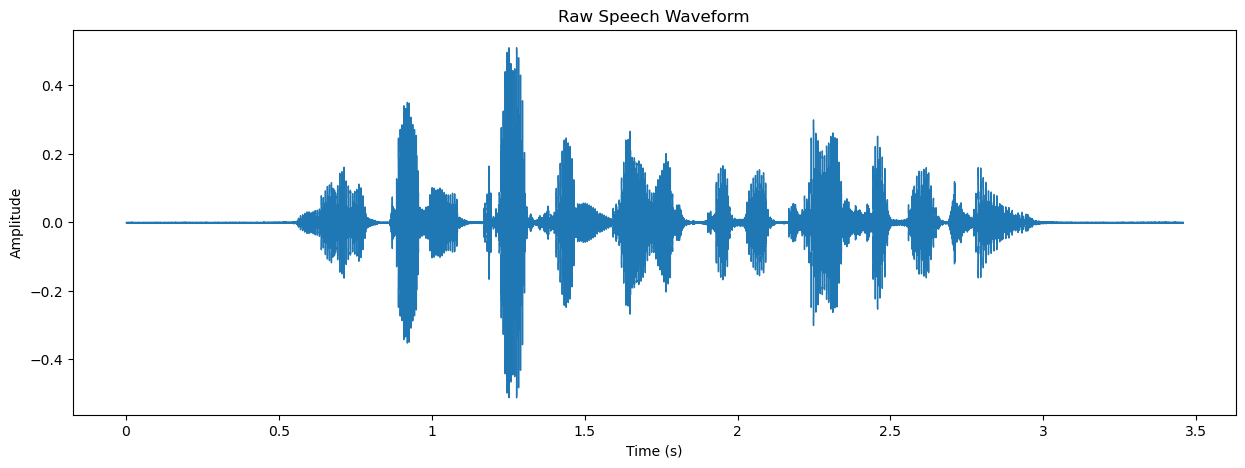

In [9]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(samples, sr=sample_rate)
plt.title('Raw Speech Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

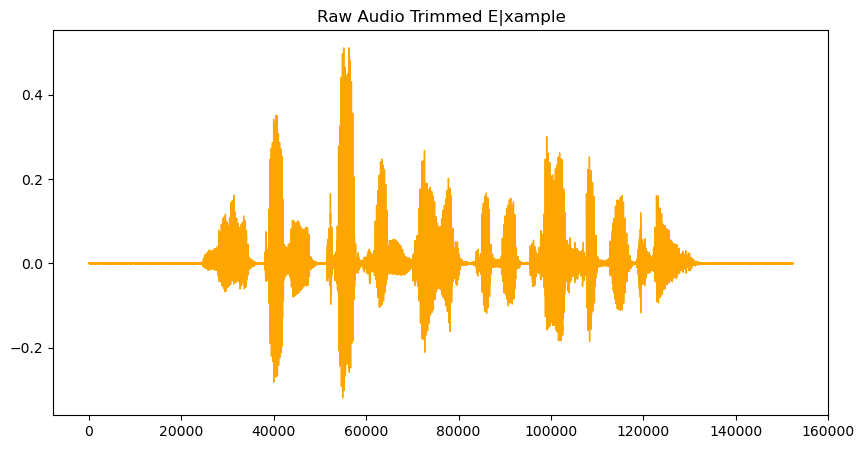

In [10]:
# Trimming leading/lagging silence
samples_trimmed, sr= librosa.effects.trim(samples, top_db=60)
pd.Series(samples_trimmed).plot(figsize=(10, 5), 
                                lw=1, 
                                title='Raw Audio Trimmed E|xample', 
                                color='orange')
plt.show()

In [11]:
ipd.Audio(samples_trimmed, rate=sample_rate)

In [12]:
# pca = PCA(n_components=2)
# components = pca.fit_transform(df)

# # Create a DataFrame with the PCA components
# pca_df = pd.DataFrame(data=components, columns=['Component 1', 'Component 2'])

# # Plot the results using Plotly Express
# fig = px.scatter(pca_df, x='Component 1', y='Component 2', title='PCA Components Plot')
# fig.show()

In [13]:
#from sklearn.mixture import GaussianMixture
## Create a DataFrame with the PCA components}
#pca_df = pd.DataFrame(data=components, columns=['Component 1', 'Component 2'])

## Perform Gaussian Mixture Model (GMM) clustering on PCA components
#n_components_gmm = 5  # You can adjust this based on your requirements
#gmm = GaussianMixture(n_components=n_components_gmm, random_state=42)
#pca_df['cluster'] = gmm.fit_predict(pca_df)

## Visualize the results using Plotly Express
#fig = px.scatter(pca_df, x='Component 1', y='Component 2', color='cluster', title='GMM Clustering on PCA Components')
#fig.show()

In [14]:
#from sklearn.cluster import KMeans

# Specify the number of clusters (k) for K-means
#n_clusters_kmeans = 5  # You can adjust this based on your requirements

## Perform K-means clustering on PCA components
#kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
#pca_df['kmeans_cluster'] = kmeans.fit_predict(pca_df[['Component 1', 'Component 2']])

## Visualize the results using Plotly Express
#fig_kmeans = px.scatter(pca_df, x='Component 1', y='Component 2', color='kmeans_cluster', title='K-means Clustering on PCA Components')
#fig_kmeans.show()

# Histogram plot to show that its mixture of gaussians

C:\Users\vdhan\AppData\Local\Temp\ipykernel_9092\3994740339.py:23: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




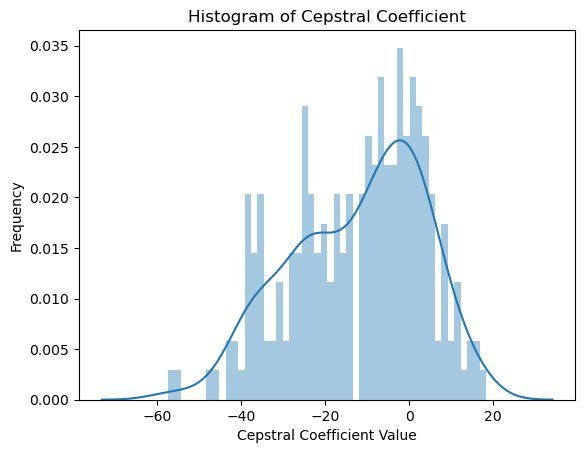

In [15]:
import seaborn as sns
# Function to extract cepstral coefficients from a speech file
def extract_cepstral_coefficients(file_path, n_mfcc=13):
    # Load the speech data
    speech, sr = librosa.load(file_path, sr=None)
    speech, _= librosa.effects.trim(speech, top_db=40)

    # Extract MFCCs (Mel-frequency cepstral coefficients)
    mfccs = librosa.feature.mfcc(y=speech, sr=sr, n_mfcc=n_mfcc)

    # Select a single cepstral coefficient (you can change the index)
    cepstral_coefficient = mfccs[6]

    return cepstral_coefficient

# Example file path (replace with your own)
speech_file_path = "../Dataset/Language-Recognition/Gujrati-Train/000010241.wav"

# Extract a single cepstral coefficient
cepstral_coefficient = extract_cepstral_coefficients(speech_file_path)

# Plot the histogram
sns.distplot(cepstral_coefficient, bins=50, kde =True)
plt.title('Histogram of Cepstral Coefficient')
plt.xlabel('Cepstral Coefficient Value')
plt.ylabel('Frequency')
plt.show()

# Main Code

In [16]:
from GMM_implementation import GMM

In [17]:
train_paths = ["../Dataset/Language-Recognition/Gujrati-Train","../Dataset/Language-Recognition/Tamil-Train","../Dataset/Language-Recognition/Telugu-Train"]
test_paths = ["../Dataset/Language-Recognition/Gujrati-Test","../Dataset/Language-Recognition/Tamil-Test","../Dataset/Language-Recognition/Telugu-Test"]

In [18]:
gmms = []
n_components_gmm = 120

In [19]:
for path in train_paths:
    X = preprocess_folder(path)
    gmm = GMM(X,n_components_gmm,tol=1e-3,cov_type='full',seed=2020)
    gmm.fit()
    gmms.append(gmm)
    print(f"{path} is done")

0.008333333333333333 0.0


ValueError: math domain error

In [ ]:
import os
# Initialize confusion matrix
confusion_matrix = np.zeros((3, 3))  # 3 classes: Gujrati, Tamil, Telugu

for idx, path in enumerate(test_paths):
    # Initialize counters for each class
    class_counts = {0: 0, 1: 0, 2: 0}
    for root, _, files in os.walk(path):
        for file in files:
            vector = preprocess(root+'/'+file)
            log_likelihood = np.zeros(len(gmms)) 
            for i in range(len(gmms)):
                gmm    = gmms[i]  #checking with each model one by one
                log_likelihood[i] = gmm.get_score(vector)
        
            winner = np.argmax(log_likelihood)
            class_counts[winner] += 1  # Increment the count for the winner class

    # Update confusion matrix
    for true_label, count in class_counts.items():
        confusion_matrix[idx, true_label] = count

# Print confusion matrix
print("Confusion Matrix:")
print("True Label \ Predicted Label\t Gujrati\t Tamil\t Telugu")
for idx, path in enumerate(test_paths):
    print(f"{path.split('/')[-1]} - Gujrati:\t{confusion_matrix[idx, 0]}\t{confusion_matrix[idx, 1]}\t{confusion_matrix[idx, 2]}")

# Calculate accuracy
accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
print(f"Overall Accuracy: {accuracy*100:.2f}%")

            

# By enabling PCA

## No improvement in this small dataset

In [ ]:
gmms = []
n_components_gmm = 50
num_pca = 10

In [ ]:
for path in train_paths:
    X = preprocess_folder(path,1,num_pca)
    gmm = GaussianMixture(n_components=n_components_gmm, random_state=2020)
    gmm.fit(X)
    gmms.append(gmm)
    print(f"{path} is done")

In [ ]:
import os
# Initialize confusion matrix
confusion_matrix = np.zeros((3, 3))  # 3 classes: Gujrati, Tamil, Telugu

for idx, path in enumerate(test_paths):
    # Initialize counters for each class
    class_counts = {0: 0, 1: 0, 2: 0}
    for root, _, files in os.walk(path):
        for file in files:
            vector = preprocess(root+'/'+file,1,num_pca)
            log_likelihood = np.zeros(len(gmms)) 
            for i in range(len(gmms)):
                gmm    = gmms[i]  #checking with each model one by one
                scores = np.array(gmm.score(vector))
                log_likelihood[i] = scores.sum()
        
            winner = np.argmax(log_likelihood)
            class_counts[winner] += 1  # Increment the count for the winner class

    # Update confusion matrix
    for true_label, count in class_counts.items():
        confusion_matrix[idx, true_label] = count

# Print confusion matrix
print("Confusion Matrix:")
print("True Label \ Predicted Label\t Gujrati\t Tamil\t Telugu")
for idx, path in enumerate(test_paths):
    print(f"{path.split('/')[-1]} - Gujrati:\t{confusion_matrix[idx, 0]}\t{confusion_matrix[idx, 1]}\t{confusion_matrix[idx, 2]}")

# Calculate accuracy
accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
print(f"Overall Accuracy: {accuracy*100:.2f}%")